In [602]:
from __future__ import print_function
from __future__ import division
import numpy as np
import scipy.stats as stats
import scipy.special as special
import scipy.interpolate as interp
import pandas as pd
import chaospy as cp
import itertools

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import pair_plot as pplt

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 4) Multivariate pdf: with Rosemblat and couplas
## Only one output or quantity of interest (QoI)

ISHIGAMI FUNCTION

Description: $ y = \sin(x_1) + a\,\sin^2(x_2) + b\,x_3^4 \,\sin(x_1) $

Dimensions: 3 

The Ishigami function of Ishigami & Homma (1990) is used as an example for uncertainty and sensitivity analysis methods, because it exhibits strong nonlinearity and nonmonotonicity. It also has a peculiar dependence on x3, as described by Sobol' & Levitan (1999). 

The values of a and b used by Crestaux et al. (2007) and Marrel et al. (2009) are: a = 7 and b = 0.1. Sobol' & Levitan (1999) use a = 7 and b = 0.05. 


In [531]:
def ishigami(a,b,wd,ws,s_ws):
    
    x1 = ws
    x2 = wd
    x3 = s_ws/10.
    
    term1 = np.sin(x1)
    term2 = a*(np.sin(x2))**2
    term3 = b*x3**4. * np.sin(x1)

    return term1 + term2 + term3

a = 7.
b = 0.1#0.8#

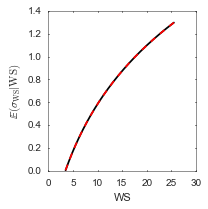

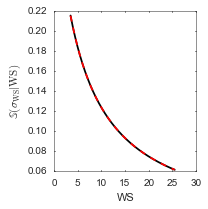

In [532]:
WS_rng = np.linspace(3.5,25.5,1000,endpoint=True)
I_ref = .16
S_sigma = (np.log( 1. + (1.4)**2./(0.75*WS_rng + 3.8)**2.))**0.5
E_sigma = np.log( I_ref*(0.75*WS_rng + 3.8) ) - S_sigma**2./2

E_sigma_pfit = np.poly1d(np.polyfit(WS_rng,E_sigma,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,E_sigma,'k')
ax.plot(WS_rng,E_sigma_pfit(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{E}(\sigma_{\mathrm{WS}}|\mathrm{WS})$')
fig.tight_layout()

S_sigma_pfit = np.poly1d(np.polyfit(WS_rng,S_sigma,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,S_sigma,'k')
ax.plot(WS_rng,S_sigma_pfit(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{S}(\sigma_{\mathrm{WS}}|\mathrm{WS})$')
fig.tight_layout()

In [533]:
dist_wd = cp.Uniform(-np.pi,np.pi)
dist_ws = cp.Weibull(shape=2., scale=8.)
dist_sigma_ws = cp.Lognormal(mu=E_sigma_pfit(dist_ws), sigma=S_sigma_pfit(dist_ws))

dist_X = cp.J(dist_wd,dist_ws,dist_sigma_ws)
dist_U = cp.J(cp.Uniform(),cp.Uniform(),cp.Uniform())

### a) MC with Halton sampling

In [534]:
N_MC=int(1e5)
sample_inputs = dist_X.sample(size=N_MC,rule='H')
sample_u = np.array([ishigami(a,b,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

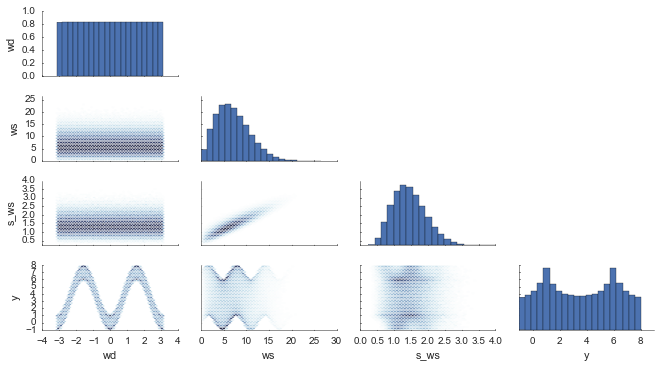

In [535]:
df_MC = pd.DataFrame(columns=['wd','ws','s_ws','y'],data=np.vstack([sample_inputs,sample_u]).T)
g=sns.PairGrid(df_MC,size=1.3,aspect=1.8,diag_sharey=False)
#g.map_lower(plt.scatter,alpha=0.2)
g.map_lower(plt.hexbin, gridsize=40, color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15, as_cmap=True))
g.map_diag(plt.hist,bins=20) 
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False) 
g.savefig('Figures/4_Ishigami_MC_sample.pdf')

In [607]:
N_eval = int(1e5)
w_eval = dist_U.sample(size=N_eval,rule='M')
x_eval = dist_X.inv(w_eval)

### b) RBF with Greedy algorithm

In [608]:
def RBF_step(w,u,epsilon):
    return interp.Rbf(w[0,:],
                      w[1,:],
                      w[2,:],
                      u,
                      function='gaussian',
                      epsilon=epsilon)

In [609]:
#initial points
w0 = np.vstack([np.array(list(itertools.product(*zip([1e-2,1e-2,1e-2],[0.99,0.99,0.99])))),
               (dist_U.sample(size=50,rule='H')).T]).T
x0 = dist_X.inv(w0)
u0 = np.array([ishigami(a,b,*node) for node in x0.T])
N_i = len(w0[0,:])
print(N_i)

58


In [610]:
epsilon = cp.Normal(0.5,0.2).sample(5,rule='M')
epsilon

array([ 0.30651569,  0.41385454,  0.5       ,  0.58614546,  0.69348431])

In [611]:
pred = np.array([RBF_step(w0,u0,th)(w_eval[0,:],w_eval[1,:],w_eval[2,:]) for th in epsilon])

In [612]:
E_pred = np.mean(pred,axis=0)
S_pred = np.std(pred,axis=0)

In [613]:
max_std = np.max(S_pred)
w_max_s = w_eval[:,np.argmax(S_pred)]

print(max_std)
print(w_max_s)

6.48782409957
[ 0.91134089  0.99912262  0.37166308]


In [614]:
columns=['wd','ws','s_ws','y']
columns_S=['wd','ws','s_ws','s_y']
df_0 = pd.DataFrame(columns=columns, data=np.vstack([x0,u0]).T)
df_E_pred = pd.DataFrame(columns=columns, data=np.vstack([x_eval,E_pred]).T)
df_S_pred = pd.DataFrame(columns=columns_S, data=np.vstack([x_eval,S_pred]).T)

In [615]:
var_list = ['wd','ws','s_ws','y']
var_labels = {'wd':'wd [rad.]','ws':'ws [m/s]','s_ws':r'$\sigma_{ws}$ [m/s]','y':'E(y)'}
var_lims = {'wd':[-3.2,3.2],'ws':[0.,25],'s_ws':[0.,4.0],'y':[-2,9]}

var_labels_S = {'wd':'wd [rad.]','ws':'ws [m/s]','s_ws':r'$\sigma_{ws}$ [m/s]','s_y':'Std(y)'}
var_lims_S = {'wd':[-3.2,3.2],'ws':[0.,25],'s_ws':[0.,4.0],'s_y':[0,6]}
df_S_pred = pd.DataFrame(columns=columns_S, data=np.vstack([x_eval,S_pred]).T)

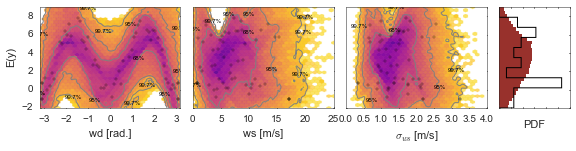

In [616]:
fig,ax= pplt.pair_plot_last_row(df_E_pred, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       num_inputs=3, bins=30, #alpha=0.7, 
                       colors=None, opt='hexbin', figsize=[8,2],xlabels=True)
fig,ax= pplt.pair_plot_last_row(df_0, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       marker='+',num_inputs=3, bins=10, alpha=0.8, 
                       colors='black', opt='scatter', fig=fig,ax=ax, figsize=[8,2],xlabels=True)
fig.savefig('Figures/4_Ishigami_RBF_'+str(N_i-1)+'.png',dpi=400)

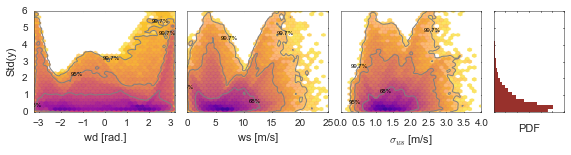

In [617]:
fig,ax= pplt.pair_plot_last_row(df_S_pred,var_list=columns_S,var_lims=var_lims_S,var_labels=var_labels_S, 
                       num_inputs=3, bins=30, #alpha=0.7, 
                       colors=None, opt='hexbin', figsize=[8,2],xlabels=True)
fig.savefig('Figures/4_Ishigami_RBF_'+str(N_i-1)+'_S.png',dpi=400)

In [567]:
sample_u_hat = E_pred#pred[1,:]
E_u_hat = np.mean(sample_u_hat,axis=0)
Std_u_hat = np.std(sample_u_hat,axis=0)
Q05_u_hat = np.percentile(sample_u_hat,5,axis=0)
Q95_u_hat = np.percentile(sample_u_hat,95,axis=0)

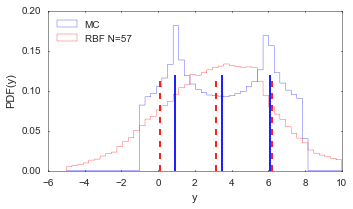

In [568]:
fig = plt.figure(figsize=[5,3])
ax = fig.add_subplot(111)
ax.hist(sample_u,
         bins=np.linspace(-5,10,50),
         histtype='step',
         color='blue',
         normed=True,
         cumulative=False,
         label='MC'
        )
ax.vlines([E_u,E_u-Std_u,E_u+Std_u],0,0.12,'blue')
#plt.vlines([Q05_u,Q95_u],0,0.12,'lightblue')

plt.hist(sample_u_hat,
         bins=np.linspace(-5,10,50),
         histtype='step',
         color='red',
         normed=True,
         cumulative=False,
         label='RBF N='+str(N_i-1)
        )
plt.vlines([E_u_hat,E_u_hat-Std_u_hat,E_u_hat+Std_u_hat],0,0.12,'red','--')
#plt.vlines([Q05_u_hat,Q95_u_hat],0,0.12,'pink')

ax.set_xlabel('y')
ax.set_ylabel('PDF(y)')
ax.legend(loc='upper left')
fig.tight_layout()
fig.savefig('Figures/4_Ishigami_RBF_'+str(N_i-1)+'_comparison.pdf')
print()

# GREEDY ALGORITHM

In [569]:
tol = 0.1
N_max = 250+1
N_i = len(w0[0,:])
while (max_std > tol)&(N_i<N_max):

    print(N_i)

    w0 = np.vstack([w0.T, w_max_s.T]).T
    x0 = dist_X.inv(w0)

    x_max_s = dist_X.inv(w_max_s)
    u_max_s = ishigami(a,b,*x_max_s)#np.array([ishigami(a,b,*node) for node in x_max_s.T])
    u0 = np.hstack([u0,u_max_s]) 

    pred = np.array([RBF_step(w0,u0,th)(w_eval[0,:],w_eval[1,:],w_eval[2,:]) for th in epsilon])

    E_pred = np.mean(pred,axis=0)
    S_pred = np.var(pred,axis=0)**0.5

    max_std = np.max(S_pred)
    print(max_std)

    i_eval = np.argmax(S_pred)

    w_max_s = w_eval[:,i_eval]
    N_i = len(w0[0,:])
    print(w_max_s)

58
6.14855588145
[  2.79997200e-04   2.18750000e-01   3.45679012e-01]
59
6.83865678314
[ 0.99865001  0.34523773  0.7769028 ]
60
5.46905551912
[  7.28992710e-03   6.06445312e-01   4.57247371e-04]
61
5.36851594603
[ 0.76543235  0.00324249  0.99980242]
62
6.98668261637
[ 0.44467555  0.17854309  0.99896696]
63
5.17034916119
[ 0.00181998  0.42578125  0.74897119]
64
6.89316883005
[ 0.00510995  0.99804688  0.63237311]
65
4.86169481727
[ 0.99170008  0.77639008  0.01284244]
66
4.82784876787
[ 0.20735793  0.00210571  0.00596115]
67
4.58663877241
[ 0.07934921  0.9979248   0.32835442]
68
3.6365337927
[ 0.96226038  0.78098297  0.99981936]
69
3.31735003195
[ 0.99783002  0.07668304  0.43945424]
70
4.73820146611
[ 0.99967     0.00539398  0.81988405]
71
3.87270266357
[ 0.71926281  0.93396759  0.99853229]
72
3.04925377249
[ 0.04351956  0.0020752   0.81450998]
73
3.27272728723
[ 0.00255997  0.00195312  0.48285322]
74
3.48812534083
[ 0.0097099   0.82714844  0.99634202]
75
2.75140850742
[ 0.18224818  0.550

In [595]:
columns=['wd','ws','s_ws','y']
df_0 = pd.DataFrame(columns=columns, data=np.vstack([x0,u0]).T)
df_E_pred = pd.DataFrame(columns=columns, data=np.vstack([x_eval,E_pred]).T)

columns_S=['wd','ws','s_ws','s_y']
var_labels_S = {'wd':'wd [rad.]','ws':'ws [m/s]','s_ws':r'$\sigma_{ws}$ [m/s]','s_y':'Std(y)'}
var_lims_S = {'wd':[-3.2,3.2],'ws':[0.,25],'s_ws':[0.,4.0],'s_y':[0,6]}
df_S_pred = pd.DataFrame(columns=columns_S, data=np.vstack([x_eval,S_pred]).T)

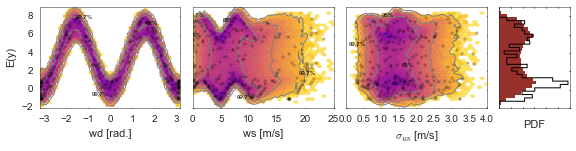

In [605]:
fig,ax= pplt.pair_plot_last_row(df_E_pred, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       num_inputs=3, bins=30, #alpha=0.7, 
                       colors=None, opt='hexbin', figsize=[8,2],xlabels=True)
fig,ax= pplt.pair_plot_last_row(df_0, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       marker='+',num_inputs=3, bins=30, alpha=0.8, 
                       colors='black', opt='scatter', fig=fig,ax=ax, figsize=[8,2],xlabels=True)
fig.savefig('Figures/4_Ishigami_RBF_'+str(N_i-1)+'.png',dpi=400)

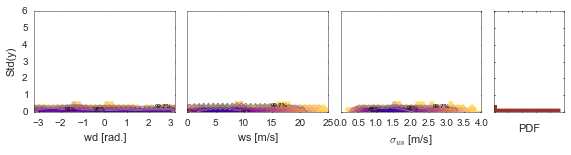

In [606]:
fig,ax= pplt.pair_plot_last_row(df_S_pred,var_list=columns_S,var_lims=var_lims_S,var_labels=var_labels_S, 
                       num_inputs=3, bins=30, #alpha=0.7, 
                       colors=None, opt='hexbin', figsize=[8,2],xlabels=True)
fig.savefig('Figures/4_Ishigami_RBF_'+str(N_i-1)+'_S.png',dpi=400)

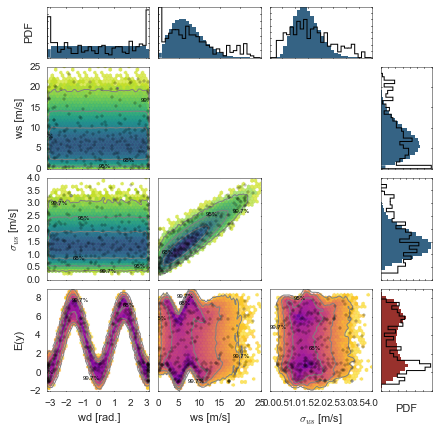

In [573]:
fig,ax= pplt.pair_plot(df_E_pred, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       num_inputs=3, bins=30, #alpha=0.7, 
                       colors=None, opt='hexbin', figsize=[6,6])
fig,ax= pplt.pair_plot(df_0, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       marker='+',num_inputs=3, bins=30, alpha=0.8, 
                       colors='black', opt='scatter', fig=fig,ax=ax, figsize=[6,6])
fig.savefig('Figures/4_Ishigami_RBF_'+str(N_i-1)+'_full.png',dpi=400)

In [574]:
sample_u_hat = E_pred#pred[1,:]
E_u_hat = np.mean(sample_u_hat,axis=0)
Std_u_hat = np.std(sample_u_hat,axis=0)
Q05_u_hat = np.percentile(sample_u_hat,5,axis=0)
Q95_u_hat = np.percentile(sample_u_hat,95,axis=0)

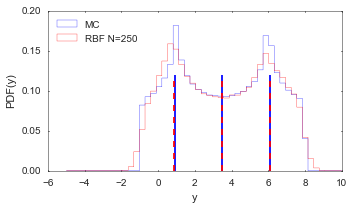

In [575]:
fig = plt.figure(figsize=[5,3])
ax = fig.add_subplot(111)
ax.hist(sample_u,
         bins=np.linspace(-5,10,50),
         histtype='step',
         color='blue',
         normed=True,
         cumulative=False,
         label='MC'
        )
ax.vlines([E_u,E_u-Std_u,E_u+Std_u],0,0.12,'blue')
#plt.vlines([Q05_u,Q95_u],0,0.12,'lightblue')

plt.hist(sample_u_hat,
         bins=np.linspace(-5,10,50),
         histtype='step',
         color='red',
         normed=True,
         cumulative=False,
         label='RBF N='+str(N_i-1)
        )
plt.vlines([E_u_hat,E_u_hat-Std_u_hat,E_u_hat+Std_u_hat],0,0.12,'red','--')
#plt.vlines([Q05_u_hat,Q95_u_hat],0,0.12,'pink')

ax.set_xlabel('y')
ax.set_ylabel('PDF(y)')
ax.legend(loc='upper left')
fig.tight_layout()
fig.savefig('Figures/4_Ishigami_RBF_'+str(N_i-1)+'_comparison.pdf')
print()